# Import

In [1]:
import pandas as pd
import plotly.graph_objs as go
import string
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#import cufflinks as cf
from plotly.offline import iplot
from tqdm import tqdm

from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
import plotly.express as px

#cf.go_offline()
#cf.set_config_file(offline = False, world_readable = True)

import plotly.io as pio
pio.renderers.default='notebook'

import warnings
warnings.simplefilter('ignore')

In [2]:
from numpy.linalg import svd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

In [3]:
from surprise import Reader
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import Dataset, accuracy
#from surprise.model_selection import cross_validate
#from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNBaseline
from surprise import SlopeOne
from surprise import CoClustering

In [4]:
from rectools import Columns
from rectools.dataset import Dataset
from rectools.models import ImplicitItemKNNWrapperModel
from rectools.metrics import (
    Precision,
    Accuracy,
    NDCG,
    IntraListDiversity,
    Serendipity,
    calc_metrics,
)

In [5]:
from implicit.nearest_neighbours import TFIDFRecommender

In [6]:
import os
us = os.getcwd()
us

'/Users/liliyaivannikova/Documents/project/git/RecSys_Films'

In [7]:
if 'liliyaivannikova' in us:
    PATH = r'/Users/liliyaivannikova/Documents/project/ml-latest/'
    movies = pd.read_csv(PATH + r'movies.csv')
    rating = pd.read_csv(PATH + r'ratings.csv')
elif 'Владислав' in us:
    movies = pd.read_csv(r'dataset/movies.csv')
    rating = pd.read_csv(r'dataset/ratings.csv')

In [8]:
print(f'''
movies: {movies.shape}
rating: {rating.shape}
''')


movies: (86537, 3)
rating: (33832162, 4)



In [9]:
movies.columns = [col.upper() for col in movies.columns]
movies.head()

,MOVIEID,TITLE,GENRES
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
movies['REALEASE'] = movies['TITLE'].str.extract("\((\d{4})\)", expand=True)
movies['REALEASE'] = pd.to_datetime(movies['REALEASE'], format='%Y')
movies['REALEASE'] = movies['REALEASE'].dt.year
movies['TITLE'] = movies['TITLE'].str[:-7]

In [11]:
movies.head()

,MOVIEID,TITLE,GENRES,REALEASE
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men,Comedy|Romance,1995.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II,Comedy,1995.0


In [12]:
dfx = movies['GENRES'].str.get_dummies(sep='|')
for col in dfx.columns:
    dfx[col] = dfx[col].astype('int8')


In [13]:
movies = pd.concat([movies, dfx], axis=1) #.drop(columns=['GENRES'])
movies['TITLE'] = movies['TITLE'].astype('category')
movies['REALEASE'] = movies['REALEASE'].astype('float16')

In [14]:
movies['GENRES'] = movies['GENRES'].str.replace('|', ',')

In [15]:
movies.head()

,MOVIEID,TITLE,GENRES,REALEASE,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,"Adventure,Animation,Children,Comedy,Fantasy",1995.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,"Adventure,Children,Fantasy",1995.0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,"Comedy,Romance",1995.0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,"Comedy,Drama,Romance",1995.0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,Comedy,1995.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [16]:
rating.columns = [col.upper() for col in rating.columns]
rating.head()

,USERID,MOVIEID,RATING,TIMESTAMP
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [17]:
df = movies.merge(rating, how="left", on="MOVIEID")
df.head()

,MOVIEID,TITLE,GENRES,REALEASE,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,USERID,RATING,TIMESTAMP
0,1,Toy Story,"Adventure,Animation,Children,Comedy,Fantasy",1995.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,1.0,4.0,1.225735e+09
1,1,Toy Story,"Adventure,Animation,Children,Comedy,Fantasy",1995.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,2.0,5.0,8.358160e+08
2,1,Toy Story,"Adventure,Animation,Children,Comedy,Fantasy",1995.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,7.0,4.0,9.745180e+08
3,1,Toy Story,"Adventure,Animation,Children,Comedy,Fantasy",1995.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,10.0,3.0,1.430666e+09
4,1,Toy Story,"Adventure,Animation,Children,Comedy,Fantasy",1995.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,12.0,5.0,8.625007e+08


# Обработка полей

In [18]:
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], unit='s')

In [24]:
#df['RATING'] = df['RATING'].astype('float16')

In [19]:
df.head()

,MOVIEID,TITLE,GENRES,REALEASE,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,USERID,RATING,TIMESTAMP
0,1,Toy Story,"Adventure,Animation,Children,Comedy,Fantasy",1995.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,1.0,4.0,2008-11-03 17:52:19
1,1,Toy Story,"Adventure,Animation,Children,Comedy,Fantasy",1995.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,2.0,5.0,1996-06-26 19:06:11
2,1,Toy Story,"Adventure,Animation,Children,Comedy,Fantasy",1995.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,7.0,4.0,2000-11-18 03:27:04
3,1,Toy Story,"Adventure,Animation,Children,Comedy,Fantasy",1995.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,10.0,3.0,2015-05-03 15:19:54
4,1,Toy Story,"Adventure,Animation,Children,Comedy,Fantasy",1995.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,12.0,5.0,1997-05-01 15:32:18


<font color='red'> **Убрал записи  пустыми значениями ~3298, это около 0.01%, фигня короче, можно сносить.** </font>

In [20]:
df.shape

(33835460, 27)

In [21]:
df = df[~((df.TIMESTAMP.isna())|(df.USERID.isna())|(df.RATING.isna()))]

# IMDb формула для посетителей без оценок

https://en.wikipedia.org/wiki/IMDb

$$ w= \frac{R*v + C*m}{v + m}$$
где:

- w - взвешенный рейтинг по фильму;
- v - количество оценок по фильму;
- m - минимальное количество оценок, необходимое для попадания в число 250 лучших фильмов;
- R - средняя оценка фильма;
- C - среднее число оценок.

In [22]:
stat_movies = df.groupby(['MOVIEID'])['RATING'].agg(['count', 'mean']).reset_index()

In [23]:
stat_movies.head()

,MOVIEID,count,mean
0,1,76813,3.893508
1,2,30209,3.278179
2,3,15820,3.171271
3,4,3028,2.868395
4,5,15801,3.076957


In [24]:
m = int(stat_movies['count'].quantile(0.9))
m

263

In [25]:
C = stat_movies["mean"].mean()
C

3.0127060991458974

In [26]:
stat_movies.shape

(83239, 3)

In [27]:
df_IMDb = stat_movies.query('count > @m')
df_IMDb.shape

(8309, 3)

In [28]:
print(movies.shape)
df_IMDb_full = movies.merge(df_IMDb, on = ['MOVIEID'], how = 'inner')
df_IMDb_full.head()
print(df_IMDb_full.shape)

(86537, 24)
(8309, 26)


In [29]:
def weighted_rating(data, m, C):

    return (data['mean']*data['count'] + C*m)/(data['count']+m)

In [30]:
df_IMDb_full['SCORE'] = weighted_rating(df_IMDb_full, m, C)

In [31]:
df_IMDb_full = df_IMDb_full.sort_values('SCORE', ascending=False)
df_IMDb_full.head(5)

,MOVIEID,TITLE,GENRES,REALEASE,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,count,mean,SCORE
274,318,"Shawshank Redemption, The","Crime,Drama",1994.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,122296,4.416792,4.413779
7566,159817,Planet Earth,Documentary,2006.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3015,4.448093,4.332929
661,858,"Godfather, The","Crime,Drama",1972.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,75004,4.326603,4.322012
7709,170705,Band of Brothers,"Action,Drama,War",2001.0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,2835,4.423986,4.304177
8028,202439,Parasite,"Comedy,Drama",2019.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,12399,4.329946,4.302586


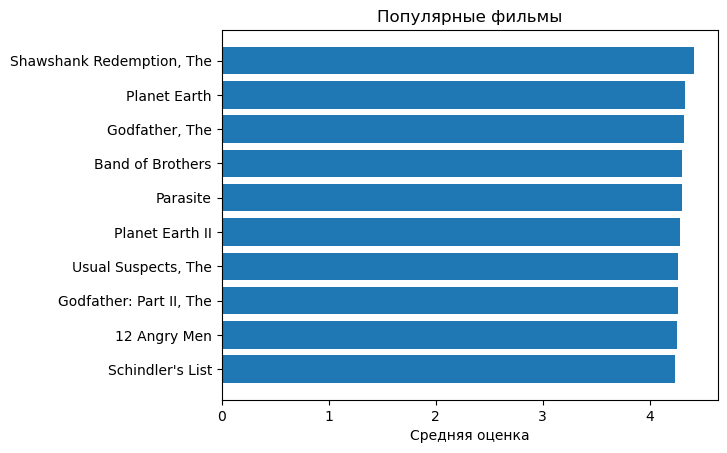

In [32]:
top_n = 10
plt.barh(df_IMDb_full['TITLE'].head(top_n), df_IMDb_full['SCORE'].head(top_n))
plt.gca().invert_yaxis()
plt.xlabel('Средняя оценка')
plt.title('Популярные фильмы');

In [33]:
dfx.columns

Index(['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western'],
      dtype='object')

In [34]:
# рекомендация по жанру
movies_genre = df_IMDb_full.loc[df_IMDb_full['Drama'] == 1]

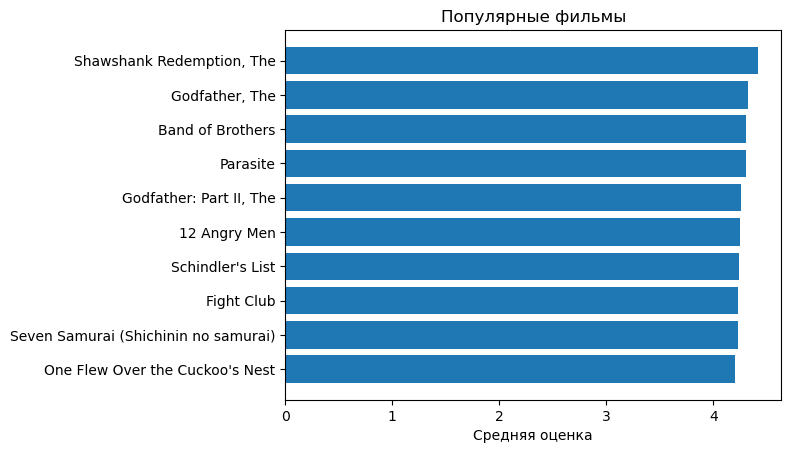

In [35]:
top_n = 10
plt.barh(movies_genre['TITLE'].head(top_n), movies_genre['SCORE'].head(top_n))
plt.gca().invert_yaxis()
plt.xlabel('Средняя оценка')
plt.title('Популярные фильмы');